In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

In [2]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Load data 

In [4]:
train=pd.read_csv("train_predict_loan_AV.csv")
test=pd.read_csv("test_predict_load_AV.csv")

## From problem statement.

### Variables------------------------Description
2. Loan_ID-------------------->Unique Loan ID
3. Gender--------------------->Male/ Female
4. Married-------------------->Applicant married (Y/N)
5. Dependents----------------->Number of dependents
6. Education------------------>Applicant Education (Graduate/ Under Graduate)
7. Self_Employed--------------->Self employed (Y/N)
8. ApplicantIncome------------->Applicant income
9. CoapplicantIncome----------->Coapplicant income
10. LoanAmount----------------->Loan amount in thousands
11. Loan_Amount_Term----------->Term of loan in months
12. Credit_History------------->credit history meets guidelines
13. Property_Area-------------->Urban/ Semi Urban/ Rural
14. Loan_Status---------------->(Target) Loan approved (Y/N)




### Looking at data 

In [5]:
train.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [6]:
train.shape

(614, 13)

In [7]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [8]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [10]:
for feature in train.columns:
    print('{} feature:----> {} unique values'.format(feature,len(train[feature].value_counts())))

Loan_ID feature:----> 614 unique values
Gender feature:----> 2 unique values
Married feature:----> 2 unique values
Dependents feature:----> 4 unique values
Education feature:----> 2 unique values
Self_Employed feature:----> 2 unique values
ApplicantIncome feature:----> 505 unique values
CoapplicantIncome feature:----> 287 unique values
LoanAmount feature:----> 203 unique values
Loan_Amount_Term feature:----> 10 unique values
Credit_History feature:----> 2 unique values
Property_Area feature:----> 3 unique values
Loan_Status feature:----> 2 unique values


### Lets do univarite analysis

In [11]:
def univariate(df ,column):
    plt.figure()
    ax=sns.countplot(data=df,x=column,palette='Set2')
    # total only consider the non-null values
    total=df[column].notnull().sum()
    
    for p in ax.patches:
        height=p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f} %'.format((height/total)*100),
            ha="center") 
    plt.title("count and % of {} feature".format(column))

In [12]:
## first let have look at categorical variable

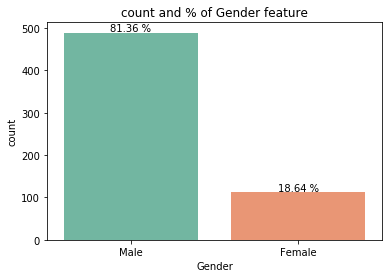

In [13]:
univariate(train,'Gender')

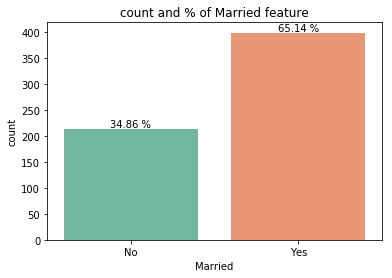

In [14]:
univariate(train,'Married')

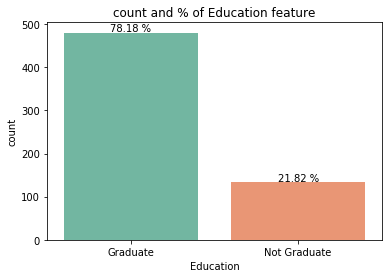

In [15]:
univariate(train,'Education')

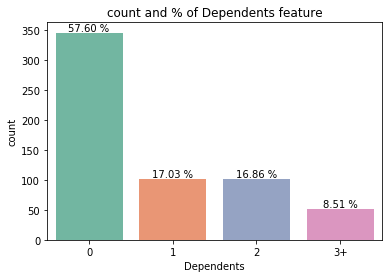

In [16]:
univariate(train,'Dependents')

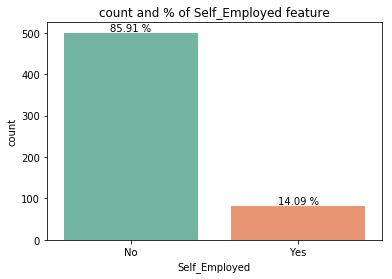

In [17]:
univariate(train,'Self_Employed')

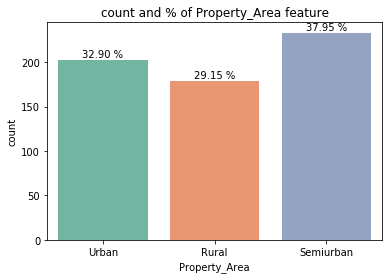

In [18]:
univariate(train,'Property_Area')

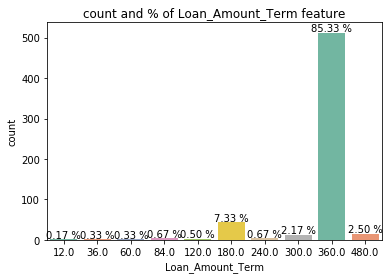

In [19]:
univariate(train,'Loan_Amount_Term')

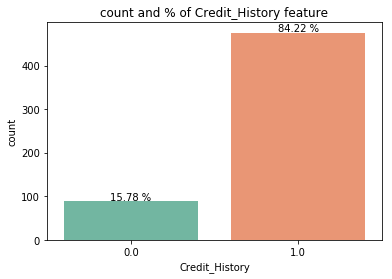

In [20]:
univariate(train,'Credit_History')

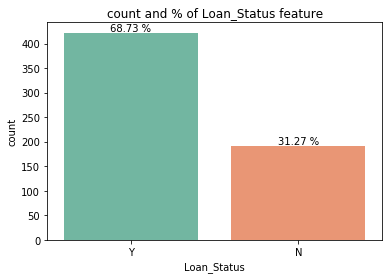

In [21]:
univariate(train,'Loan_Status')

### observation :
'''' 
1. there is relative high percentage of male (>75%) who applied for Home Loan as comopared to its female counter part
2. More Married people applied
3. more then 3/4 of applicants are graduate
4. More then half of the applicants has no dependents
5. More the 80% are not self_employed
6. people having property in every area (rural ,semi-urban,urban ) applied with no major significant differnce in numbers
7. Almost 80% meets the guidelines
8. Most of the applicants were given Loan
'''

### since target varible is object we replace N with 0 and Y with 1

In [22]:
train.replace({'Loan_Status':{'Y':1,'N':0}},inplace=True)

### Let's Look at summary statistics 

In [23]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,614.000000,614.000000,592.000000,600.00000,564.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,0.687296
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,0.463973
min,150.000000,0.000000,9.000000,12.00000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,1.000000


### now lets explore continuous variable with distplot

In [24]:
def continuous(df,column):
    plt.figure(figsize=(20,10)) 
    ax=sns.distplot(df[column],rug=True,bins=50,norm_hist=False)
    plt.title('Distribution of {}'.format(column))
    #loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    #ax.xaxis.set_major_locator(loc)
    
    

/home/fasial/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


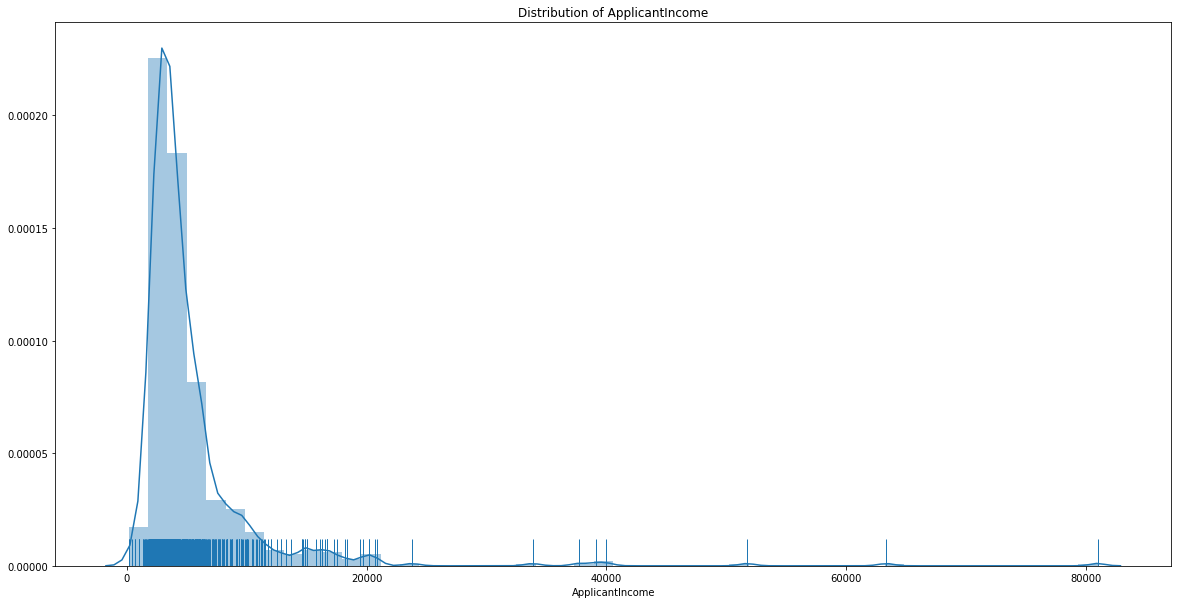

In [25]:
_=continuous(train,"ApplicantIncome");

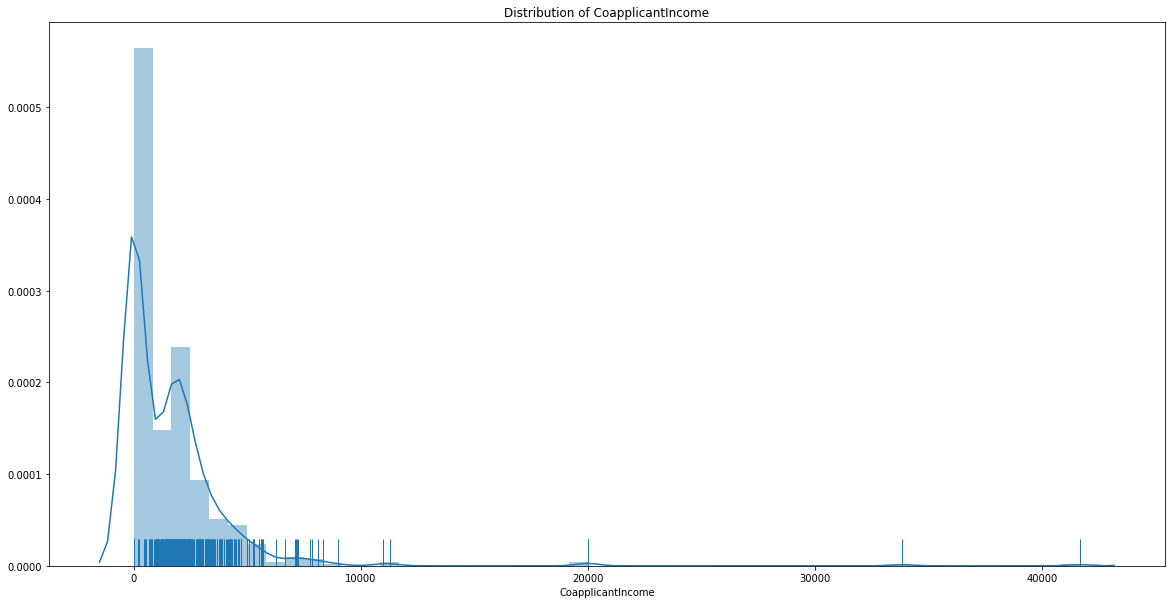

In [26]:
continuous(train,"CoapplicantIncome")

/home/fasial/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fasial/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/fasial/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/fasial/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


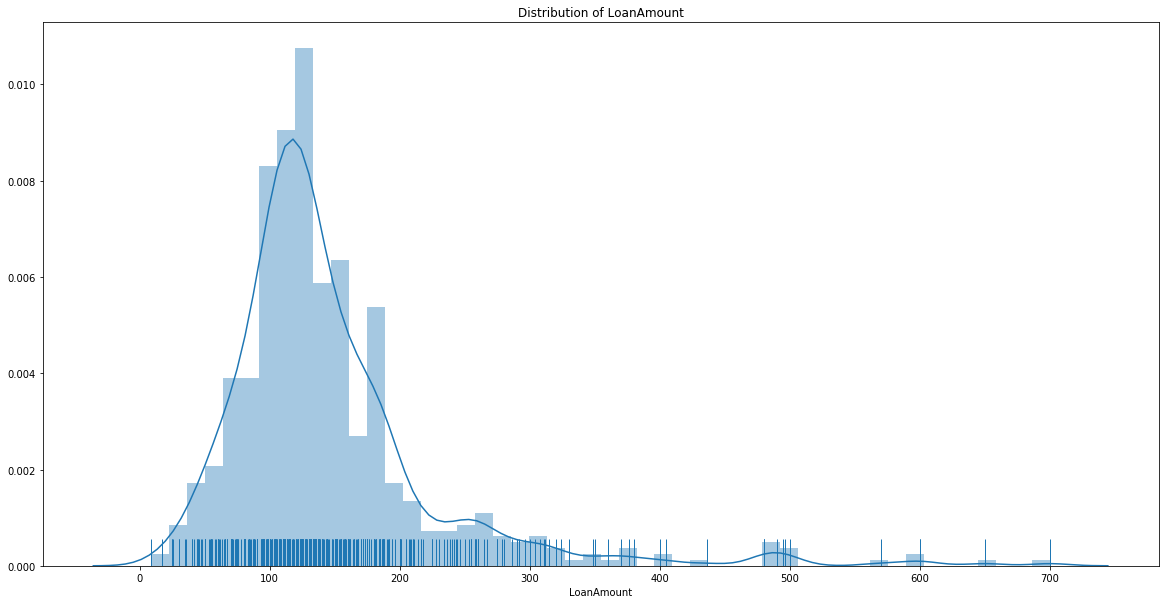

In [27]:
_=continuous(train,"LoanAmount");


''''
1. All three of continuous variable has outliers
2. ApplicantIncome and 'CoapplicantIncome' are skewed towards right and need tranformation for better prediction model
''''


### Now lets do bivariate analysis taking each feature corresponding target variable(Loan_Status)


In [28]:
def bivariate(df ,column,target):
    plt.figure(figsize=(8,8))
    feature=df[column].sort_values()
    ax=sns.countplot(data=df,x=target,hue=feature,dodge=True,palette="husl")
    total=train[column].value_counts().sort_index()
    # unique=len(target.value_counts())
    for i,p in enumerate(ax.patches,start=0):
        height=p.get_height()
        print(height,total[i//2])
        ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f} %'.format((height/total[i//2])*100),
            ha="center") 
    plt.title("count and % of {} feature".format(column))
    print(df[column].value_counts())

### starting with categorical feature

#### Here percentage is calculated with respected to a particular sub -group of a feature

In [29]:
target="Loan_Status"

37 112
75 112
150 489
339 489
Male      489
Female    112
Name: Gender, dtype: int64


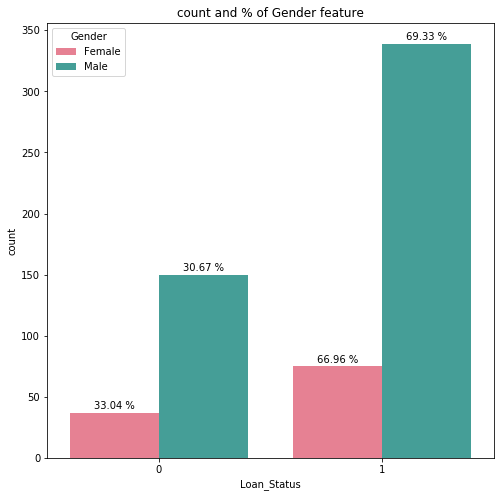

In [30]:
bivariate(train,"Gender",target)

79 213
134 213
113 398
285 398
Yes    398
No     213
Name: Married, dtype: int64


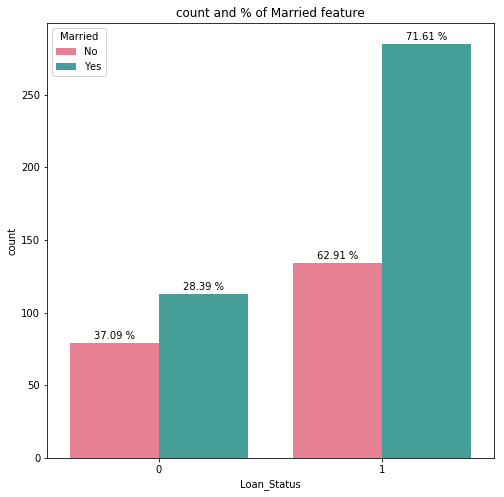

In [31]:
bivariate(train,"Married",target)

107 345
238 345
36 102
66 102
25 101
76 101
18 51
33 51
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


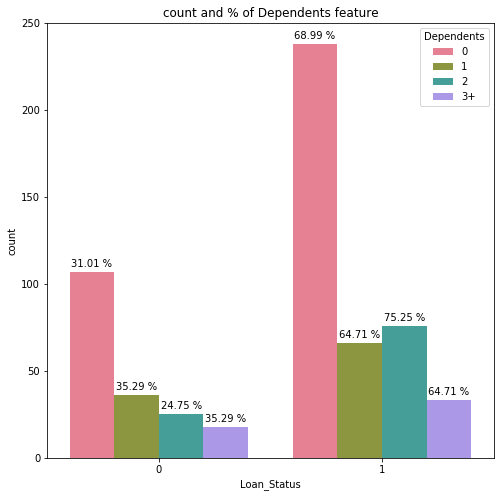

In [32]:
bivariate(train,"Dependents",target)

140 480
340 480
52 134
82 134
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


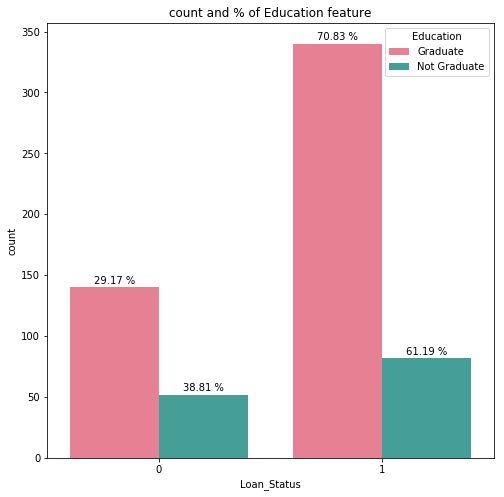

In [33]:
bivariate(train,"Education",target)

157 500
343 500
26 82
56 82
No     500
Yes     82
Name: Self_Employed, dtype: int64


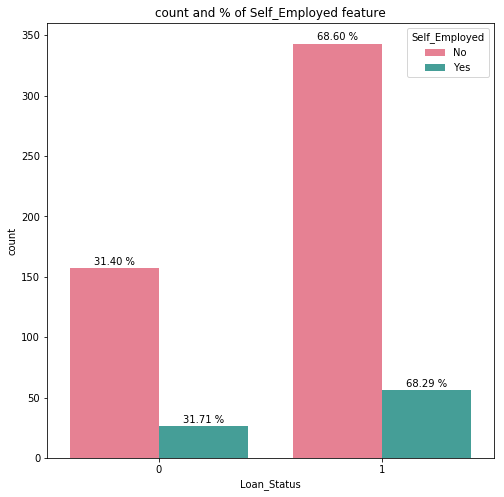

In [34]:
bivariate(train,"Self_Employed",target)

82 89
7 89
97 475
378 475
1.0    475
0.0     89
Name: Credit_History, dtype: int64


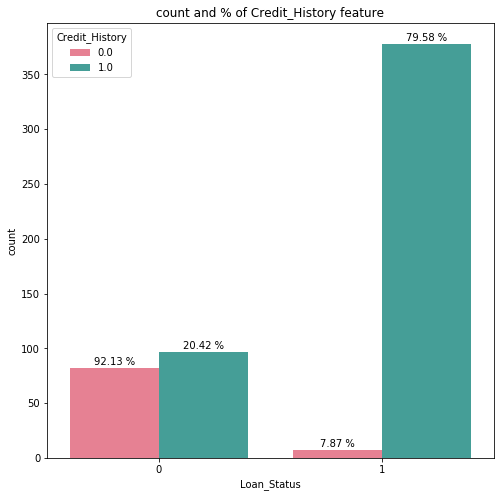

In [35]:
bivariate(train,"Credit_History",target)

69 179
110 179
54 233
179 233
69 202
133 202
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


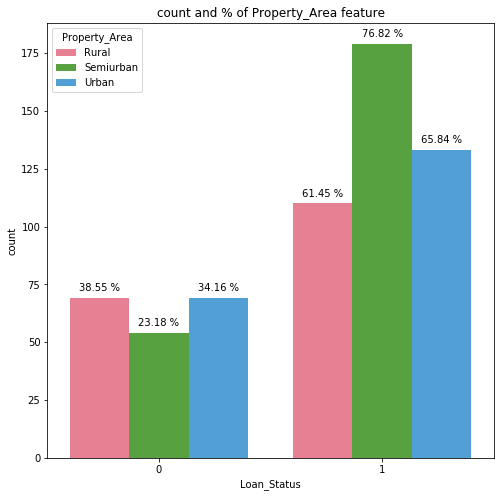

In [36]:
bivariate(train,"Property_Area",target)

### Observations

1. The number of Loan approval and rejection for both male and female is  nearly close. Hence it indicates no significant relation of target and Gender 
2. Married applicants seemed to get more approval then unmarried one.
3. Applicants with no dependents is more likely to get loan approval . we would consider converting to into two classes ,0=no dependents and 1 = with dependents
4. there is clear evidence that Graduate is more likely to get Loan_approval and vice-versa
5. both sub group of self empolyed shows similar approval and rejections w.r.t the no. of applicants in each group
6. credit history which meets guildlines have more approval then its counterparts.
7. It seems that apprval for semi urban property area is highest and rural is lowest


### Now let's explore continuous feature w.r.t target variable

In [37]:
#### first have a look at summary statistics
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,614.000000,614.000000,592.000000,600.00000,564.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,0.687296
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,0.463973
min,150.000000,0.000000,9.000000,12.00000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,1.000000


In [38]:
def cont_bivariate(df,column,mval):
    plt.figure(figsize=(12,8))
    sns.stripplot(y=column,data=train,x='Loan_Status',jitter=True)
    plt.ylim(0,mval)
    plt.title("Loan_status and {} plot".format(column))

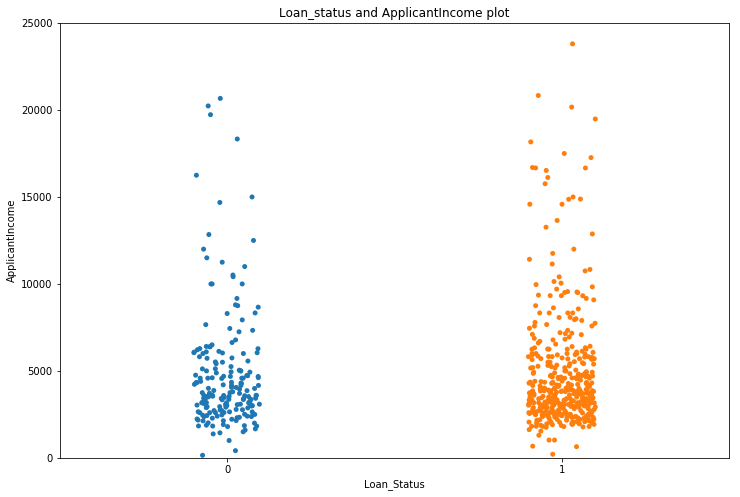

In [39]:
cont_bivariate(train,'ApplicantIncome',25000)

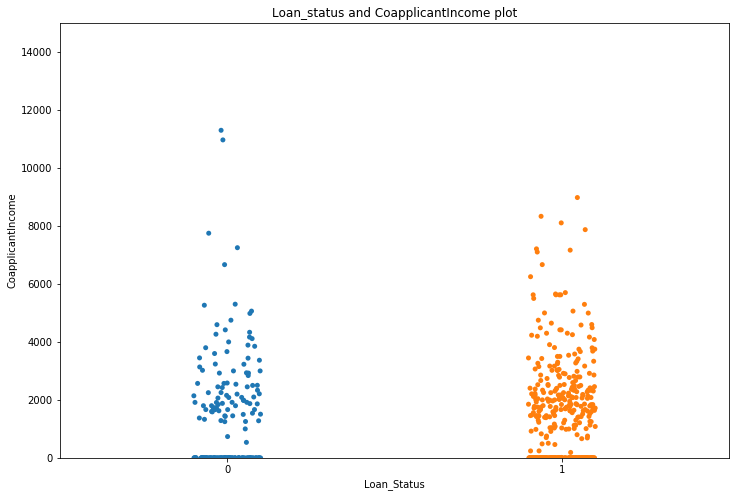

In [40]:
cont_bivariate(train,'CoapplicantIncome',15000)

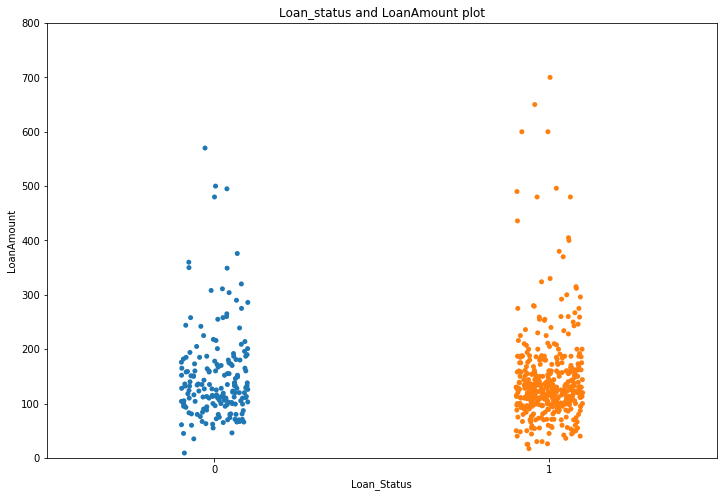

In [41]:
cont_bivariate(train,'LoanAmount',800)

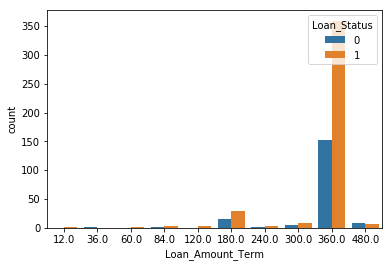

In [42]:
approval=train[train['Loan_Status']==1]['Loan_Amount_Term']
sns.countplot(x="Loan_Amount_Term",data=train,hue='Loan_Status')

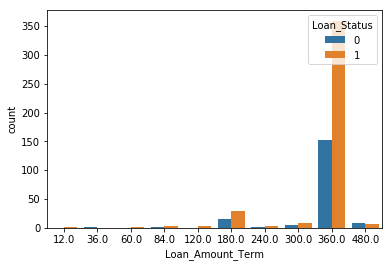

In [43]:
rejection=train[train['Loan_Status']==0]['Loan_Amount_Term']
sns.countplot(x="Loan_Amount_Term",data=train,hue='Loan_Status')

1. from domain knowledge we know that an applicant's chances of Loan_approval increaese with either of increase in 
applicants income or increase in coapplicant's income .
2. visualisation gives no strong evidence to reject the hyposthesis we acquire from domain ,hence we will stick to  our null hyptheses : approval rate or chances increases with increase in either or both ,coapplicant's /applicants income

### missing values (count and percentage)

In [44]:
def calculate_missing_percent(df):
    missing=pd.DataFrame()
    percentage=[]
    count=[]
    total_record=len(df)
    for feature in df.columns:
        cnt=df[feature].isna().sum()
        cal=cnt/total_record
        percentage.append(cal*100)
        count.append(cnt)
    missing['feature']=df.columns
    missing['count of missing values']=count
    missing['missing %']=percentage
    return missing
        
    

### detect outliers (visualization and removal using Z score (3std))

In [45]:
def outlier_box(df,column):
    plt.figure(figsize=(8,12))
    sns.boxplot(data=df,y=column)

In [46]:
def outlier_violin(df,column):
    plt.figure(figsize=(8,12))
    sns.violinplot(data=df,y=column)

In [47]:
def Z_score(df,column):
    mean=df[column].mean()
    std=df[column].std()
    cut_off=std*3
    lower,upper=mean-cut_off,mean+cut_off
    return df[(df[column]<upper)&(df[column]>lower)]

## Explore each feature and Handle missing values 

### summary at a glance

In [48]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,614.000000,614.000000,592.000000,600.00000,564.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,0.687296
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,0.463973
min,150.000000,0.000000,9.000000,12.00000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,1.000000


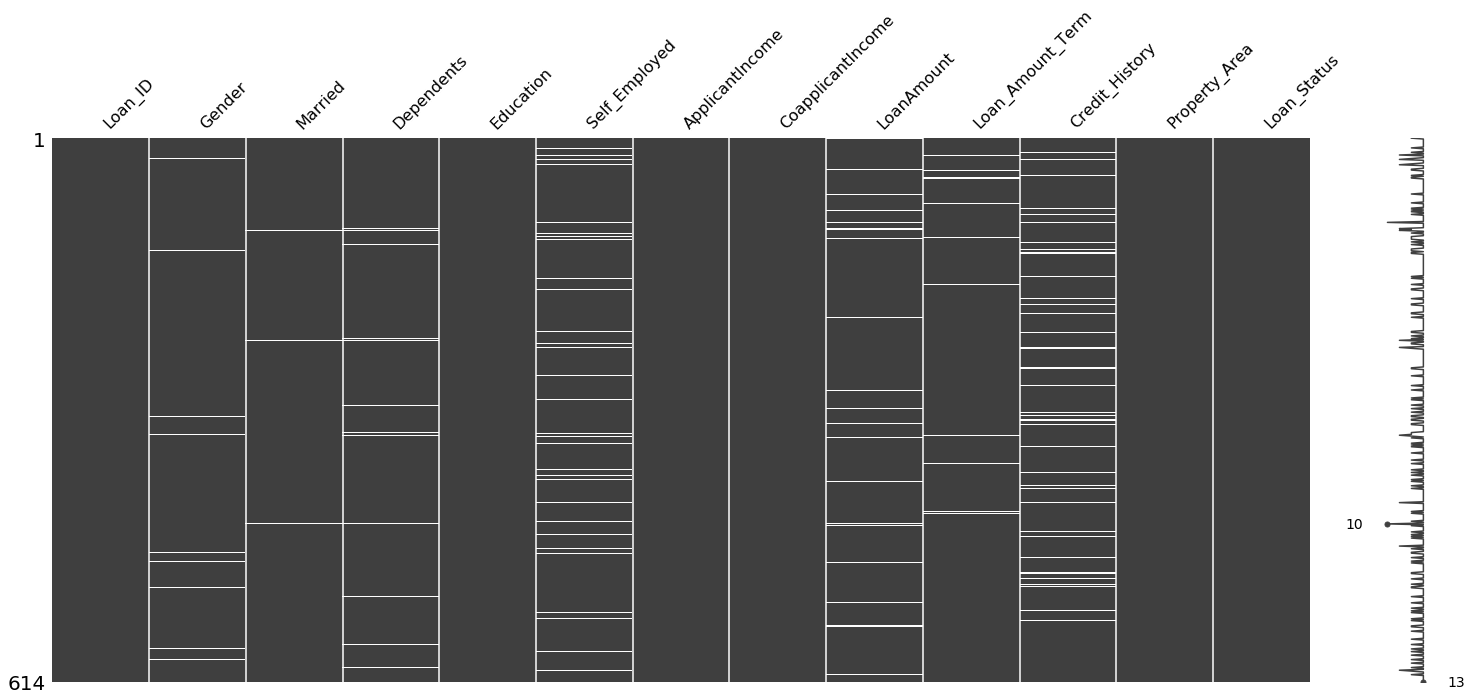

In [49]:
ms.matrix(train)

### Coapplicant_Income and Applicant_Income together

In [50]:
calculate_missing_percent(train)

,feature,count of missing values,missing %
0,Loan_ID,0,0.000000
1,Gender,13,2.117264
2,Married,3,0.488599
3,Dependents,15,2.442997
4,Education,0,0.000000
5,Self_Employed,32,5.211726
6,ApplicantIncome,0,0.000000
7,CoapplicantIncome,0,0.000000
8,LoanAmount,22,3.583062
9,Loan_Amount_Term,14,2.280130


#### no missing value in any of ApplicantIncome and CoapplicantIncome

1. we know form domain knowledge addition of both CoapplicantIncome and ApplicantIncome decide ability 
 of an appicant to repay his/her Loan Amount.
2. Hence we would combine both togther into one feature ,Total_Income=CoapplicantIncome+ApplicantIncome

#### combine 'ApplicantIncome' and 'CoapplicantIncome' to get Total_Income and drop these features further

In [51]:
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome']
train.drop(labels=["ApplicantIncome",'CoapplicantIncome'],axis=1,inplace=True)

In [52]:
test['Total_Income']=test['ApplicantIncome']+test['CoapplicantIncome']
test.drop(labels=["ApplicantIncome",'CoapplicantIncome'],axis=1,inplace=True)

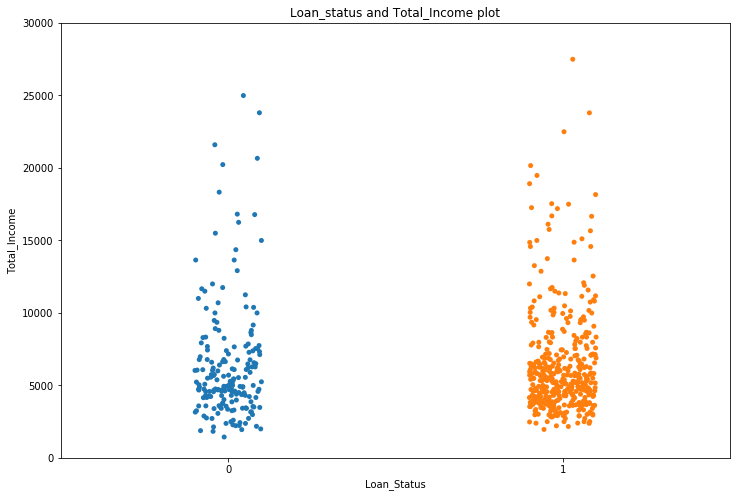

In [53]:
cont_bivariate(train,"Total_Income",30000);

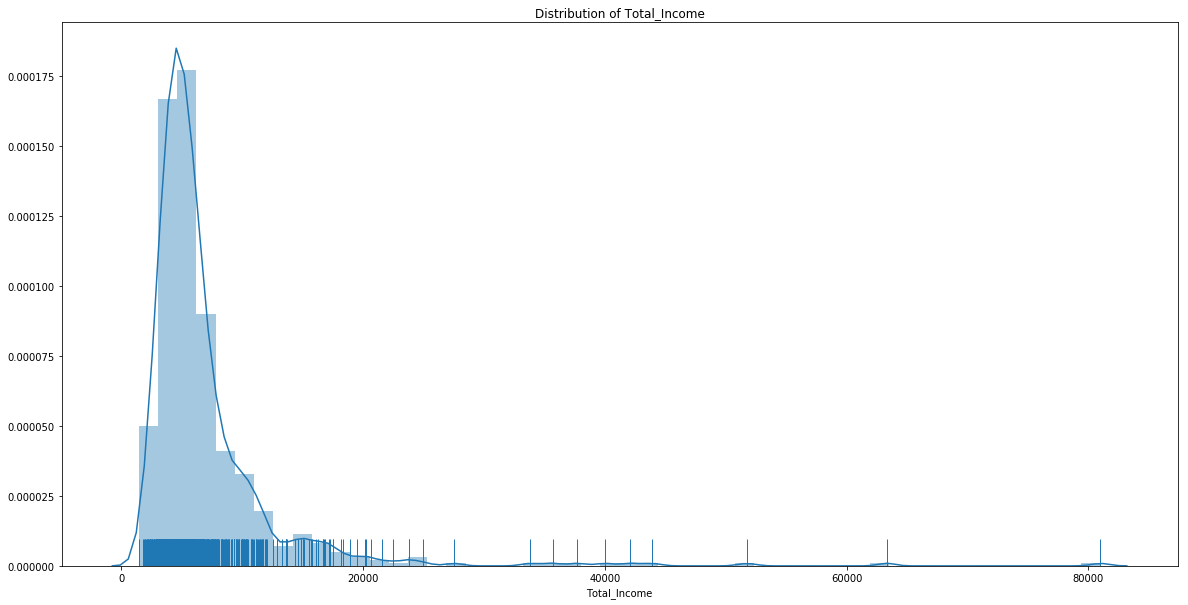

In [54]:
continuous(train,'Total_Income');

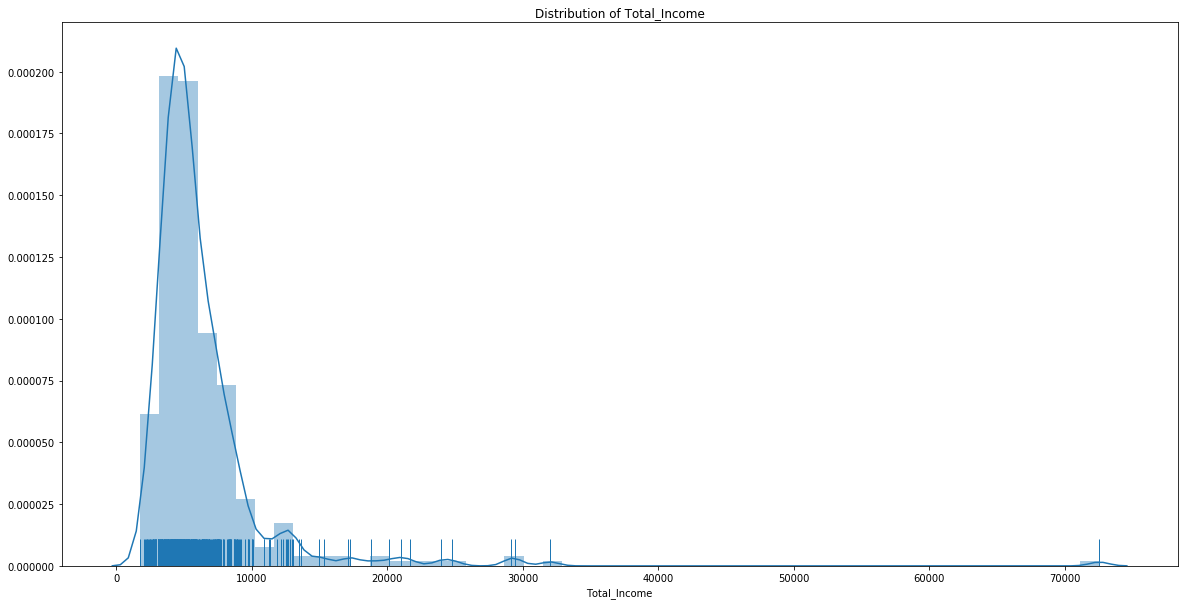

In [55]:
continuous(test,'Total_Income');

## Gender 
we will certainly drop this columns since this column shows no particular trends with target feature as expected from our domain Knowledge.But before dropping we will see whether or not it can help in filling missing values in other features like dependents

### Lets try to find if there is any relation between Married ,Gender and dependets w.r.t Loan_Status


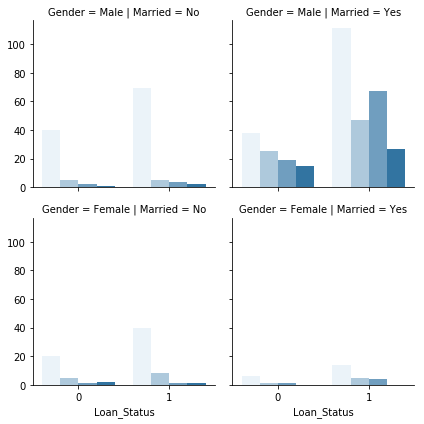

In [56]:
relation = sns.FacetGrid(train, col="Married",  row="Gender",legend_out=True,palette='hasl')
relation.map(sns.countplot,'Loan_Status',hue=train['Dependents'],order=None,)

#### this shows that most of the applicats are married male in both sub groups of target  variable

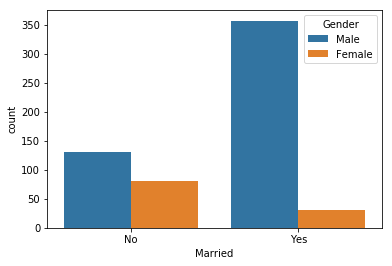

In [57]:
sns.countplot(data=train,x='Married',hue='Gender')

#### this shows that in male category most of them are married and is reverse in female

## Married feature (filling NaN)

In [58]:
train[train['Married'].isna()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
104,LP001357,Male,NaN,NaN,Graduate,No,160.0,360.0,1.0,Urban,1,4570.0
228,LP001760,Male,NaN,NaN,Graduate,No,158.0,480.0,1.0,Semiurban,1,4758.0
435,LP002393,Female,NaN,NaN,Graduate,No,NaN,240.0,1.0,Semiurban,1,10047.0


#### we would replace NaN in Married column based on Gender if male then Yes,else No

In [59]:
train.loc[(train.Married.isna())&(train.Gender=="Male"),'Married']='Yes'
train.loc[(train.Married.isna())&(train.Gender=="Female"),'Married']='No'

In [60]:
test.loc[(test.Married.isna())&(test.Gender=="Male"),'Married']='Yes'
test.loc[(test.Married.isna())&(test.Gender=="Female"),'Married']='No'

In [61]:
train[train['Married'].isna()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income


#### since Married is nominal categorical value we will use dummy encoding once dependents missing values is fixed

## Dependents feature 

1. since dependents is ordinal categorical feature ,hence we will do level encoding ,we would make two categories 0 representing no dependents 
2. And  1 to represents 1 or more dependents 
3. since  high percentage of applicants have no dependents and applicants also appicants with no dependents are more likely to get Loan approval

In [62]:
train.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [63]:
train.loc[(train.Dependents!="0")&(train.Dependents.notnull()),'Dependents']=1
train.loc[(train.Dependents=="0"),'Dependents']=0


In [64]:
test.loc[(test.Dependents!="0")&(test.Dependents.notnull()),'Dependents']=1
test.loc[(test.Dependents=="0"),'Dependents']=0


In [65]:
train.Dependents.value_counts()


0    345
1    254
Name: Dependents, dtype: int64

In [66]:
test.Dependents.value_counts()

0    200
1    157
Name: Dependents, dtype: int64

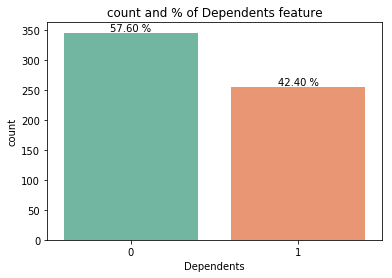

In [67]:
univariate(train,'Dependents')

107 345
238 345
79 254
175 254
0    345
1    254
Name: Dependents, dtype: int64


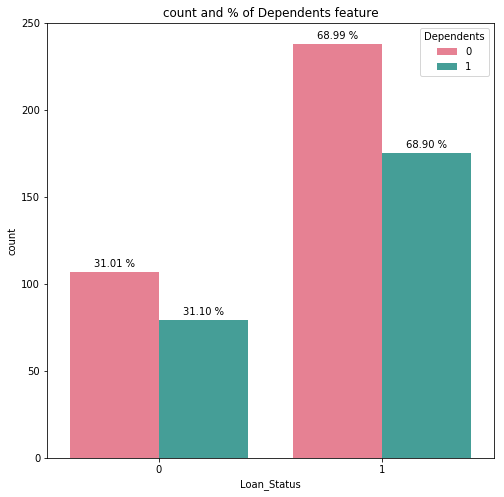

In [68]:
bivariate(train,'Dependents',target)

In [69]:
''''
form the domain knowledge we know a person with dependents is less likely to get loan_approval then it counter 
part with no dependents keeping all other constraints same,since a person with dependents is bound with higher 
commitment unlike unlike a person who has no dependents.
Though in both sub-groups of dependents shows no major difference ,
this graphs and our analysis gives  no good reason to reject the hypothesis we derive from domaim knowledge.
hence we would not drop this feature and would try to fill NaN values if any.''';

In [70]:
calculate_missing_percent(train)

,feature,count of missing values,missing %
0,Loan_ID,0,0.000000
1,Gender,13,2.117264
2,Married,0,0.000000
3,Dependents,15,2.442997
4,Education,0,0.000000
5,Self_Employed,32,5.211726
6,LoanAmount,22,3.583062
7,Loan_Amount_Term,14,2.280130
8,Credit_History,50,8.143322
9,Property_Area,0,0.000000


80 112
29 112
258 489
219 489
Male      489
Female    112
Name: Gender, dtype: int64


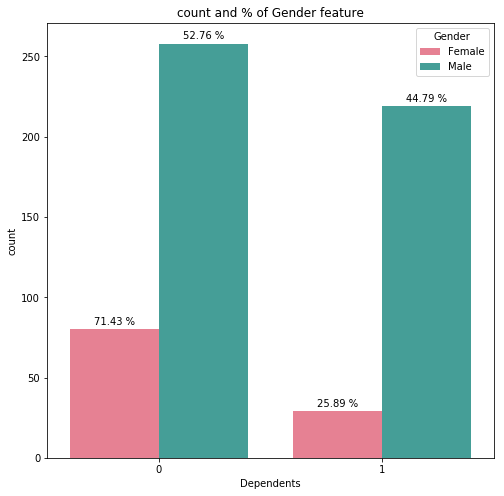

In [71]:
bivariate(train,'Gender','Dependents')

171 214
38 214
174 400
216 400
Yes    400
No     214
Name: Married, dtype: int64


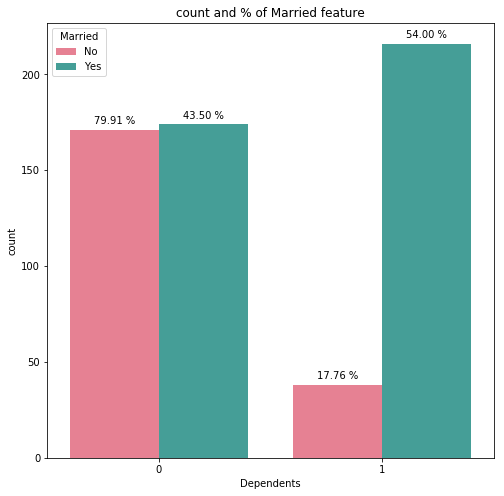

In [72]:
bivariate(train,'Married','Dependents')

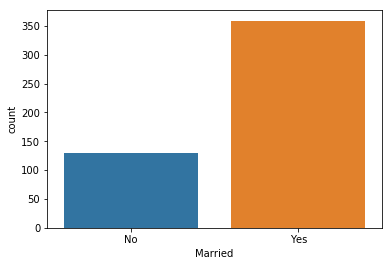

In [73]:
sns.countplot(train[train['Gender']=='Male']['Married'])

1. 70% of female applicant has no dependets and 52% of male applicant has no depents.
2. out of total unmarried applicants more then 80% has no dependents .
3. Most of Male are Married.
4. hence we impute 0 when an applicant is either Not Married or her Gender is Female,else 1

In [74]:
train[train.Dependents.isna()].head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
102,LP001350,Male,Yes,NaN,Graduate,No,NaN,360.0,1.0,Urban,1,13650.0
104,LP001357,Male,Yes,NaN,Graduate,No,160.0,360.0,1.0,Urban,1,4570.0
120,LP001426,Male,Yes,NaN,Graduate,No,180.0,360.0,1.0,Rural,1,8334.0
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,138.0,360.0,1.0,Urban,0,4735.0
228,LP001760,Male,Yes,NaN,Graduate,No,158.0,480.0,1.0,Semiurban,1,4758.0


In [75]:
train.Dependents.value_counts()

0    345
1    254
Name: Dependents, dtype: int64

In [76]:
train.loc[(train.Dependents.isna())&((train.Married=='No')|(train.Gender=='Female')),'Dependents']=0
train.loc[train.Dependents.isna(),'Dependents']=1


In [77]:
train.Dependents.value_counts()

0    350
1    264
Name: Dependents, dtype: int64

In [78]:
test.loc[(test.Dependents.isna())&((test.Married=='No')|(test.Gender=='Female')),'Dependents']=0
test.loc[test.Dependents.isna(),'Dependents']=1

## Self_Employed feature

157 500
343 500
26 82
56 82
No     500
Yes     82
Name: Self_Employed, dtype: int64


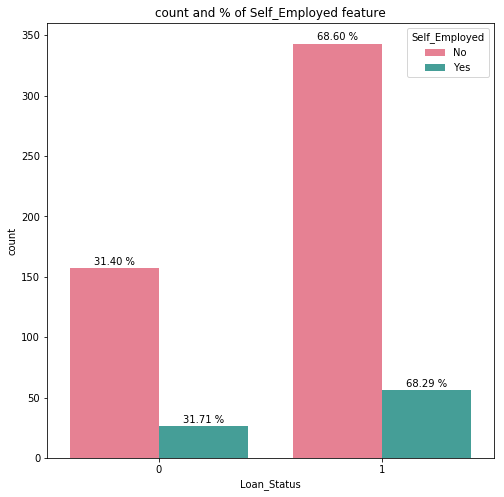

In [79]:
bivariate(train,"Self_Employed",target)

1.  % of applicant in both sub groups has roughly same likelihood for approval and rejection 
2. approval rate in of self_employed == No is 68.76% and where self_employed == Yes is 67.90%
3. Though % likelihood of   employed(68.86%) vs self_employed(67.90%) not much but,there is no good reson to drop this feature,since from domain knowledge we know that for a given income employed is more preferred over self_employed,since employed is more likely to have more security in terms of income.

In [80]:
calculate_missing_percent(train)

,feature,count of missing values,missing %
0,Loan_ID,0,0.000000
1,Gender,13,2.117264
2,Married,0,0.000000
3,Dependents,0,0.000000
4,Education,0,0.000000
5,Self_Employed,32,5.211726
6,LoanAmount,22,3.583062
7,Loan_Amount_Term,14,2.280130
8,Credit_History,50,8.143322
9,Property_Area,0,0.000000


In [81]:
calculate_missing_percent(test)

,feature,count of missing values,missing %
0,Loan_ID,0,0.000000
1,Gender,11,2.997275
2,Married,0,0.000000
3,Dependents,0,0.000000
4,Education,0,0.000000
5,Self_Employed,23,6.267030
6,LoanAmount,5,1.362398
7,Loan_Amount_Term,6,1.634877
8,Credit_History,29,7.901907
9,Property_Area,0,0.000000


In [82]:
train.Self_Employed.value_counts(normalize=True)

No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64

389 480
65 480
111 134
17 134
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


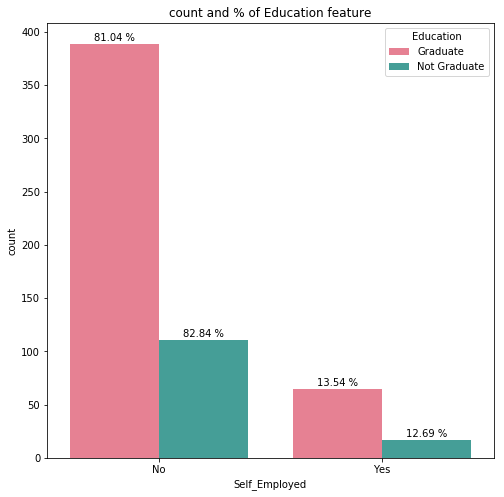

In [83]:
bivariate(train,'Education',"Self_Employed")

89 112
15 112
402 489
63 489
Male      489
Female    112
Name: Gender, dtype: int64


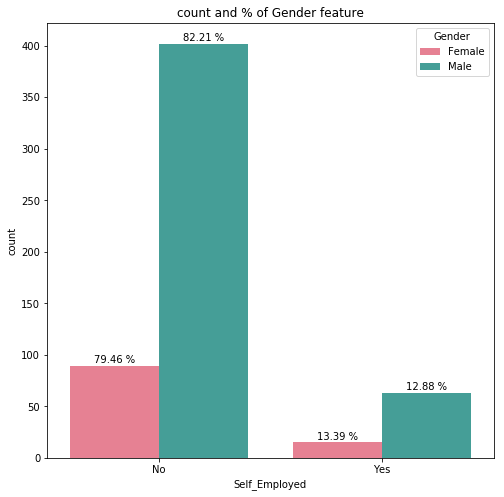

In [84]:
bivariate(train,'Gender',"Self_Employed")

1. 85% of the applicants are not self_employed 
2. both are graph show no matter whether an applicant is graduate or not ,whether male or female ,he/she is more likely to be employed
3. hece we fill all NaN with No

In [85]:
train.Self_Employed.fillna('No',inplace=True);
test.Self_Employed.fillna('No',inplace=True);

## Loan_Amount_Term feature 

In [86]:
calculate_missing_percent(train)

,feature,count of missing values,missing %
0,Loan_ID,0,0.000000
1,Gender,13,2.117264
2,Married,0,0.000000
3,Dependents,0,0.000000
4,Education,0,0.000000
5,Self_Employed,0,0.000000
6,LoanAmount,22,3.583062
7,Loan_Amount_Term,14,2.280130
8,Credit_History,50,8.143322
9,Property_Area,0,0.000000


In [87]:
train.describe()

,Dependents,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Total_Income
count,614.000000,592.000000,600.00000,564.000000,614.000000,614.000000
mean,0.429967,146.412162,342.00000,0.842199,0.687296,7024.705081
std,0.495475,85.587325,65.12041,0.364878,0.463973,6458.663872
min,0.000000,9.000000,12.00000,0.000000,0.000000,1442.000000
25%,0.000000,100.000000,360.00000,1.000000,0.000000,4166.000000
50%,0.000000,128.000000,360.00000,1.000000,1.000000,5416.500000
75%,1.000000,168.000000,360.00000,1.000000,1.000000,7521.750000
max,1.000000,700.000000,480.00000,1.000000,1.000000,81000.000000


In [88]:
train.Loan_Amount_Term.value_counts(normalize=True)

360.0    0.853333
180.0    0.073333
480.0    0.025000
300.0    0.021667
84.0     0.006667
240.0    0.006667
120.0    0.005000
36.0     0.003333
60.0     0.003333
12.0     0.001667
Name: Loan_Amount_Term, dtype: float64

1. this we have already seen in univariate and bivatiate analysis ,hence we would impute NaN with feature's mode 

In [89]:
mod=train.Loan_Amount_Term.mode()[0]

In [90]:
train.Loan_Amount_Term.fillna(mod,inplace=True)
test.Loan_Amount_Term.fillna(mod,inplace=True)

In [91]:
train.Loan_Amount_Term.isna().sum()

0

## credit History feature

In [92]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Loan_Status', 'Total_Income'],
      dtype='object')

In [93]:
sns.set_style('darkgrid')
_=plt.figure(figsize=(8,10))

<Figure size 576x720 with 0 Axes>

17 112
84 112
69 489
382 489
Male      489
Female    112
Name: Gender, dtype: int64


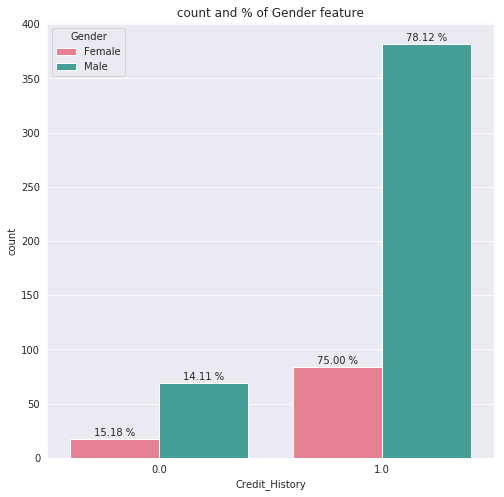

In [94]:
bivariate(train,'Gender','Credit_History')

32 214
168 214
57 400
307 400
Yes    400
No     214
Name: Married, dtype: int64


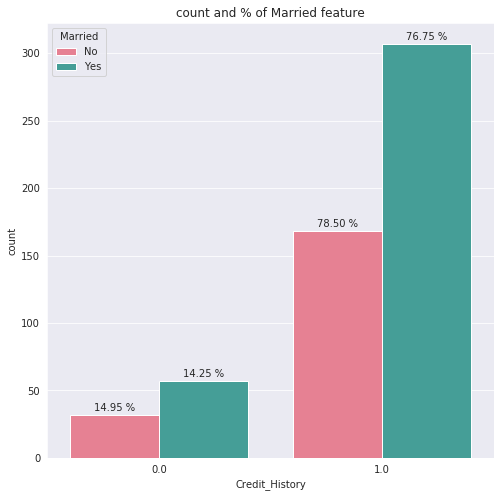

In [95]:
bivariate(train,'Married','Credit_History')

32 214
168 214
57 400
307 400
Yes    400
No     214
Name: Married, dtype: int64


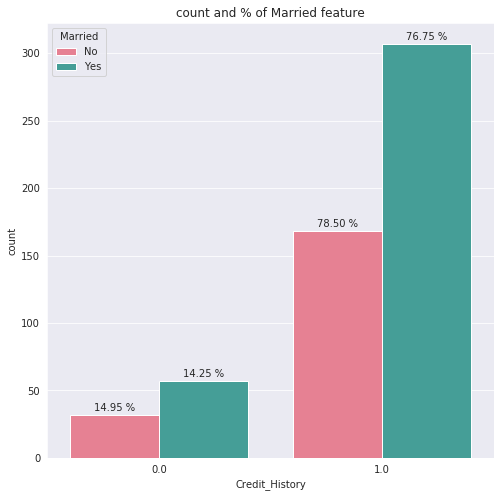

In [96]:
bivariate(train,'Married','Credit_History')

28 179
137 179
30 233
187 233
31 202
151 202
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


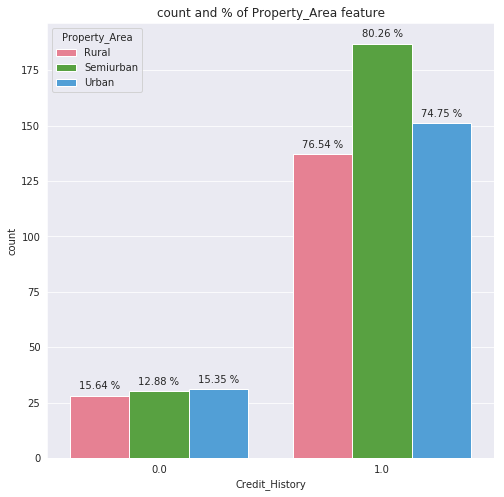

In [97]:
bivariate(train,'Property_Area','Credit_History')

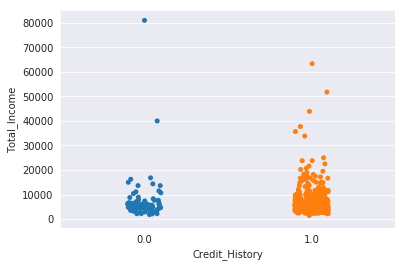

In [98]:

sns.stripplot(x='Credit_History',y='Total_Income',jitter=True,data=train)

In [99]:
train.Credit_History.value_counts(normalize=True)

1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64

In [100]:
train.Credit_History.isna().sum()

50

1. visualistaion show no relation of credit history with other features
2. since it related to target variable,we would fill NaN with its mode which appear more then 84 of the feature columns

In [101]:
mod=train.Credit_History.mode()[0]

In [102]:
train.Credit_History.fillna(mod,inplace=True)
test.Credit_History.fillna(mod,inplace=True)

## Property_Area feature 

1. though property is not very significant as far as Loan_approval is concerned ,but it may give insights like 
Education,Total_income,self_Employed of an applicant and may or may not  share indirect relation with 
target variable
2. we assume that rural has least % of graduate and urban has most graduate
3. Total income in rural is least and it is highest in urban 
4. Rural area may high % self employed(farming) as compared to empoyed.

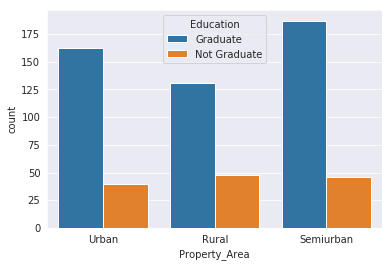

In [103]:
sns.countplot(x='Property_Area',data=train,hue='Education')

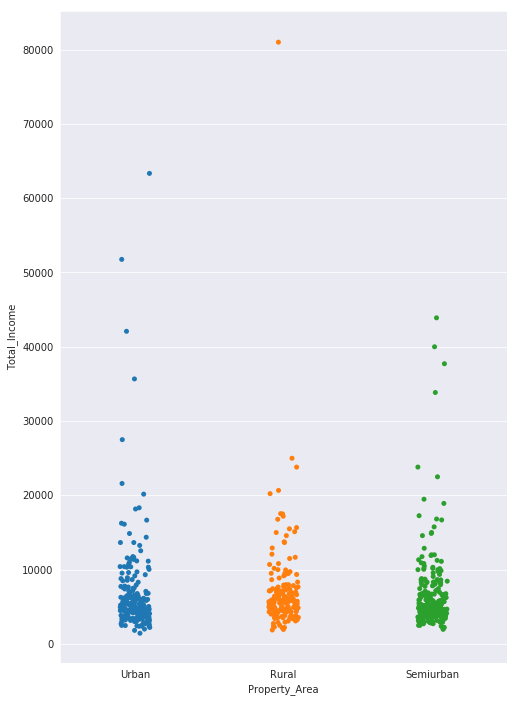

In [104]:
plt.figure(figsize=(8,12))
sns.stripplot(x='Property_Area',y='Total_Income',jitter=True,data=train)

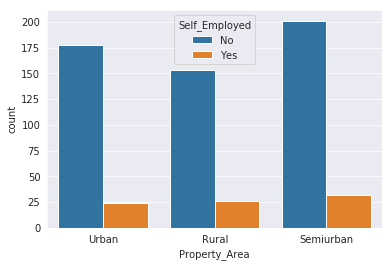

In [105]:
sns.countplot(x='Property_Area',data=train,hue='Self_Employed')

#### visualisation doesnt give clear picture lets see summary of each group

In [106]:
groups=train.groupby(['Property_Area'])
### lets denote rural with 0 ,semi-urban with 1 and urban with 2
area=[]
area_df=[]

In [107]:
train.Self_Employed.value_counts()

No     532
Yes     82
Name: Self_Employed, dtype: int64

In [108]:
for g,df in groups:
    area_df.append(df)
    area.append(g)
    
    

In [109]:
total_applicants=[]
graduate=[]
Mean_Income=[]
self_employed=[]
for df in area_df:
    total=len(df)
    total_applicants.append(total)
    total=df['Education'].notnull().sum()
    graduate.append((len(df[df['Education']=='Graduate'])/total)*100)
    Mean_Income.append(df['Total_Income'].mean())
    total=df['Self_Employed'].notnull().sum()
    self_employed.append((len(df[df['Self_Employed']=='Yes'])/total)*100)
    
    


In [110]:
summary_stats=pd.DataFrame({'Property_Area':area,'Total_applicants':total_applicants,'Graduate %':graduate,'Mean_Income':Mean_Income,'self_Employed %':self_employed})

In [111]:
summary_stats

,Property_Area,Total_applicants,Graduate %,Mean_Income,self_Employed %
0,Rural,179,73.184358,7199.620782,14.525140
1,Semiurban,233,80.257511,6812.394850,13.733906
2,Urban,202,80.198020,7114.598020,11.881188


1. Property area gives no clear picture of its asscoiation either diretly or indriectly 
2. Also there are many factors involved like differnt Loan rates ,cost of living,etc 
3. Hence we would considering droping this feature

In [112]:
train.drop('Property_Area',axis=1,inplace=True)

In [113]:
test.drop('Property_Area',axis=1,inplace=True)

## LoanAmount feature (handling missing values)

In [114]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Total_Income
0,LP001002,Male,No,0,Graduate,No,NaN,360.0,1.0,1,5849.0
1,LP001003,Male,Yes,1,Graduate,No,128.0,360.0,1.0,0,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,66.0,360.0,1.0,1,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,120.0,360.0,1.0,1,4941.0
4,LP001008,Male,No,0,Graduate,No,141.0,360.0,1.0,1,6000.0


In [115]:
test.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income
362,LP002971,Male,Yes,1,Not Graduate,Yes,113.0,360.0,1.0,5786
363,LP002975,Male,Yes,0,Graduate,No,115.0,360.0,1.0,4867
364,LP002980,Male,No,0,Graduate,No,126.0,360.0,1.0,5243
365,LP002986,Male,Yes,0,Graduate,No,158.0,360.0,1.0,7393
366,LP002989,Male,No,0,Graduate,Yes,98.0,180.0,1.0,9200


In [116]:
train.shape

(614, 11)

In [117]:
calculate_missing_percent(train)

,feature,count of missing values,missing %
0,Loan_ID,0,0.000000
1,Gender,13,2.117264
2,Married,0,0.000000
3,Dependents,0,0.000000
4,Education,0,0.000000
5,Self_Employed,0,0.000000
6,LoanAmount,22,3.583062
7,Loan_Amount_Term,0,0.000000
8,Credit_History,0,0.000000
9,Loan_Status,0,0.000000


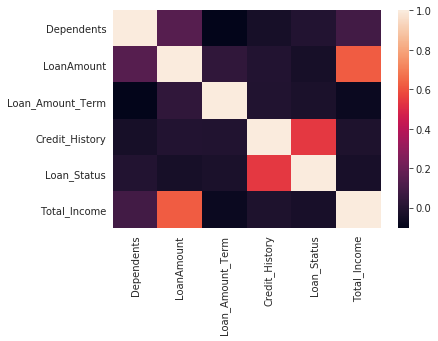

In [118]:
sns.heatmap(train.corr())

<Figure size 576x864 with 0 Axes>

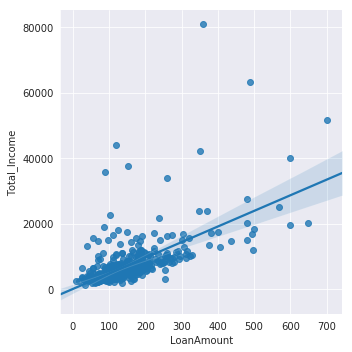

In [119]:
plt.figure(figsize=(8,12))
_=sns.lmplot(x='LoanAmount',y='Total_Income',data=train);

1. this shows there  is significant correlation between LoanAmount and Total_Income 
2. hence we would impute using ML Algorithm LinearRegression or KNN after validating which is best fit

## Let pre process our data (FE,Outliers removal,Feature_scaling,tansforamtion)

In [120]:
## drop Gender as per earlier findings

In [121]:
train.drop('Gender',axis=1,inplace=True)
test.drop('Gender',axis=1,inplace=True)

### Encoding

1. dummy encoding to of features (Nominal): Married,Self_Employed
2. LabelEncoding of feature (ordinal): Education

In [122]:
train.Education.value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [123]:
train.replace({'Graduate':1,'Not Graduate':0},inplace=True)

In [124]:
test.replace({'Graduate':1,'Not Graduate':0},inplace=True)

In [125]:
#pd.get_dummies(data=train,columns=['Married','Self_Employed'],drop_first=True)

In [126]:
train=pd.get_dummies(data=train,columns=['Married','Self_Employed'],drop_first=True)
test=pd.get_dummies(data=test,columns=['Married','Self_Employed'],drop_first=True)

In [127]:
train.head()

,Loan_ID,Dependents,Education,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Total_Income,Married_Yes,Self_Employed_Yes
0,LP001002,0,1,NaN,360.0,1.0,1,5849.0,0,0
1,LP001003,1,1,128.0,360.0,1.0,0,6091.0,1,0
2,LP001005,0,1,66.0,360.0,1.0,1,3000.0,1,1
3,LP001006,0,0,120.0,360.0,1.0,1,4941.0,1,0
4,LP001008,0,1,141.0,360.0,1.0,1,6000.0,0,0


In [128]:
test.tail()

,Loan_ID,Dependents,Education,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,Married_Yes,Self_Employed_Yes
362,LP002971,1,0,113.0,360.0,1.0,5786,1,1
363,LP002975,0,1,115.0,360.0,1.0,4867,1,0
364,LP002980,0,1,126.0,360.0,1.0,5243,0,0
365,LP002986,0,1,158.0,360.0,1.0,7393,1,0
366,LP002989,0,1,98.0,180.0,1.0,9200,0,1


1. we can derive EMI from LoanAmount and Loan_Amount_Term
2. Let do that,with the assumption that if EMI is more then the Income of applicant will be higher since ,
from the domain knoledge we know theere is a max limit of EMI based on one's Income .
3. for ex. for an employed he/she can pay maximum of 60%(may varry) of his/her slary as EMI due to rules and guidelines.
4. there is no limit on minimun payment though.


In [129]:
#### multiplied with thousand since LoanAmount is in thousand
train.LoanAmount=train.LoanAmount*1000
test.LoanAmount=test.LoanAmount*1000

In [130]:

train['EMI']=(train.LoanAmount/train.Loan_Amount_Term)
test['EMI']=(test.LoanAmount/test.Loan_Amount_Term)

Text(0.5, 1.0, 'TotalAmount vs EMI')

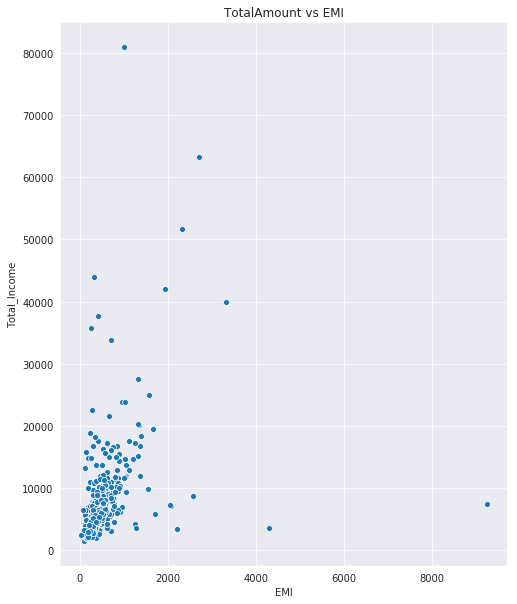

In [131]:
plt.figure(figsize=(8,10))
sns.scatterplot(x='EMI',y='Total_Income',data=train)
plt.title('TotalAmount vs EMI')

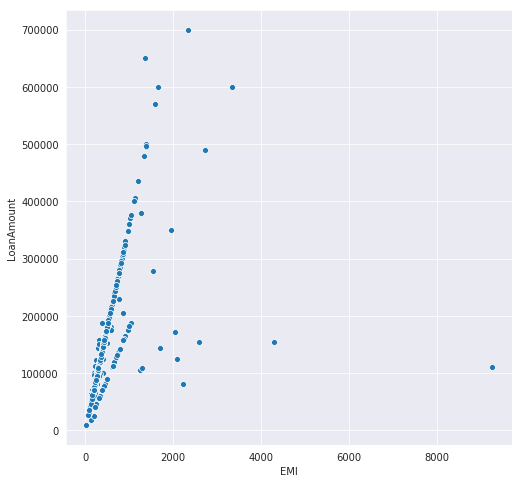

In [132]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='EMI',y='LoanAmount',data=train)

1. since it seems EMI works well ,so we will drop Loan_Amount_Term since it can be derived from EMI and LoanAmount.

In [133]:
train.drop('Loan_Amount_Term',axis=1,inplace=True)

In [134]:
test.drop('Loan_Amount_Term',axis=1,inplace=True)

In [135]:
len(train.EMI.value_counts())

237

### lets fix scaling ,skewness and normalisation

In [136]:
def Log_Transform(df,Features):
    for feature in Features:
        log=PowerTransformer(standardize=False)
        log.fit(df[[feature]])
        df[feature]=log.transform(df[[feature]])
        test[feature]=log.transform(test[[feature]])

In [137]:
def Normalization(df,Features):
    for feature in Features:
        scaler=MinMaxScaler()
        scaler.fit(df[[feature]])
        df[feature]=scaler.transform(df[[feature]])
        #test[feature]=scaler.transform(test[[feature]])



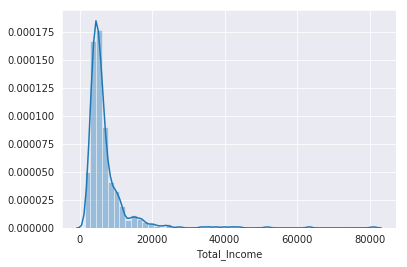

In [138]:
sns.distplot(train['Total_Income'])

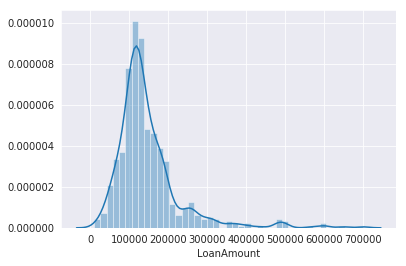

In [139]:
sns.distplot(train['LoanAmount'].dropna())

1. both these continuous features has right skewness
2. we would use MinMaxScaler to scale these features
3. then would peform log transform 
4. if needed then out drop outliers

In [140]:
train.drop(labels=['Loan_ID'],axis=1,inplace=True)


In [141]:
train.head()

,Dependents,Education,LoanAmount,Credit_History,Loan_Status,Total_Income,Married_Yes,Self_Employed_Yes,EMI
0,0,1,NaN,1.0,1,5849.0,0,0,NaN
1,1,1,128000.0,1.0,0,6091.0,1,0,355.555556
2,0,1,66000.0,1.0,1,3000.0,1,1,183.333333
3,0,0,120000.0,1.0,1,4941.0,1,0,333.333333
4,0,1,141000.0,1.0,1,6000.0,0,0,391.666667


In [142]:
test.tail()

,Loan_ID,Dependents,Education,LoanAmount,Credit_History,Total_Income,Married_Yes,Self_Employed_Yes,EMI
362,LP002971,1,0,113000.0,1.0,5786,1,1,313.888889
363,LP002975,0,1,115000.0,1.0,4867,1,0,319.444444
364,LP002980,0,1,126000.0,1.0,5243,0,0,350.000000
365,LP002986,0,1,158000.0,1.0,7393,1,0,438.888889
366,LP002989,0,1,98000.0,1.0,9200,0,1,544.444444


In [143]:
#print(stop here)

In [144]:
scaled_test=test.drop('Loan_ID',axis=1)
scaled_train=train.drop('Loan_Status',axis=1)

In [145]:
scaled_test.shape

(367, 8)

In [146]:
scaled_train.shape

(614, 8)

### scaling 

In [147]:
scaler = MinMaxScaler()
scaler.fit(scaled_train)
scaled_train= pd.DataFrame(scaler.transform(scaled_train), columns = scaled_train.columns)
#test.loc[= pd.DataFrame(scaler.fit_transform(test), columns = train.columns)

In [148]:
scaled_test= pd.DataFrame(scaler.transform(scaled_test), columns = scaled_test.columns)

In [149]:
scaled_test.describe()

,Dependents,Education,LoanAmount,Credit_History,Total_Income,Married_Yes,Self_Employed_Yes,EMI
count,367.000000,367.000000,362.000000,367.000000,367.000000,367.000000,367.000000,362.000000
mean,0.441417,0.771117,0.183983,0.839237,0.062007,0.634877,0.100817,0.053738
std,0.497234,0.420687,0.088808,0.367814,0.065354,0.482122,0.301498,0.152234
min,0.000000,0.000000,0.027496,0.000000,0.003997,0.000000,0.000000,0.007829
25%,0.000000,1.000000,0.132055,1.000000,0.034113,0.000000,0.000000,0.028606
50%,0.000000,1.000000,0.167873,1.000000,0.047299,1.000000,0.000000,0.036435
75%,1.000000,1.000000,0.215630,1.000000,0.069610,1.000000,0.000000,0.050286
max,1.000000,1.000000,0.782923,1.000000,0.893524,1.000000,1.000000,2.345980


In [150]:
scaled_train.describe()

,Dependents,Education,LoanAmount,Credit_History,Total_Income,Married_Yes,Self_Employed_Yes,EMI
count,614.000000,614.000000,592.000000,614.000000,614.000000,614.000000,614.000000,592.000000
mean,0.429967,0.781759,0.198860,0.855049,0.070172,0.651466,0.133550,0.048951
std,0.495475,0.413389,0.123860,0.352339,0.081182,0.476895,0.340446,0.056361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.131693,1.000000,0.034239,0.000000,0.000000,0.028004
50%,0.000000,1.000000,0.172214,1.000000,0.049957,1.000000,0.000000,0.036585
75%,1.000000,1.000000,0.230101,1.000000,0.076419,1.000000,0.000000,0.052334
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### imputing using KNNImputer 

In [151]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(scaled_train)
scaled_train= pd.DataFrame(imputer.transform(scaled_train),columns = scaled_train.columns)

In [152]:
scaled_test= pd.DataFrame(imputer.transform(scaled_test),columns = scaled_test.columns)

In [153]:
calculate_missing_percent(scaled_train)

,feature,count of missing values,missing %
0,Dependents,0,0.0
1,Education,0,0.0
2,LoanAmount,0,0.0
3,Credit_History,0,0.0
4,Total_Income,0,0.0
5,Married_Yes,0,0.0
6,Self_Employed_Yes,0,0.0
7,EMI,0,0.0


In [154]:
calculate_missing_percent(scaled_test)

,feature,count of missing values,missing %
0,Dependents,0,0.0
1,Education,0,0.0
2,LoanAmount,0,0.0
3,Credit_History,0,0.0
4,Total_Income,0,0.0
5,Married_Yes,0,0.0
6,Self_Employed_Yes,0,0.0
7,EMI,0,0.0


### Removing Outliers

In [155]:
scaled_train['Loan_Status']=train['Loan_Status']

/home/fasial/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


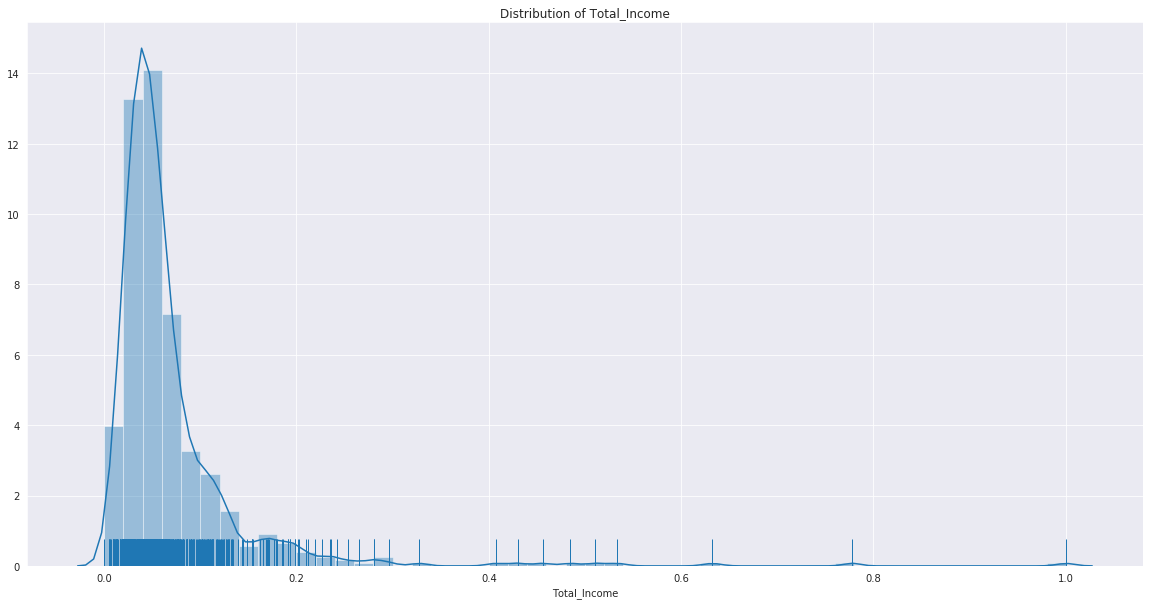

In [156]:
continuous(scaled_train,"Total_Income");

In [157]:
scaled_train=Z_score(scaled_train,'Total_Income')

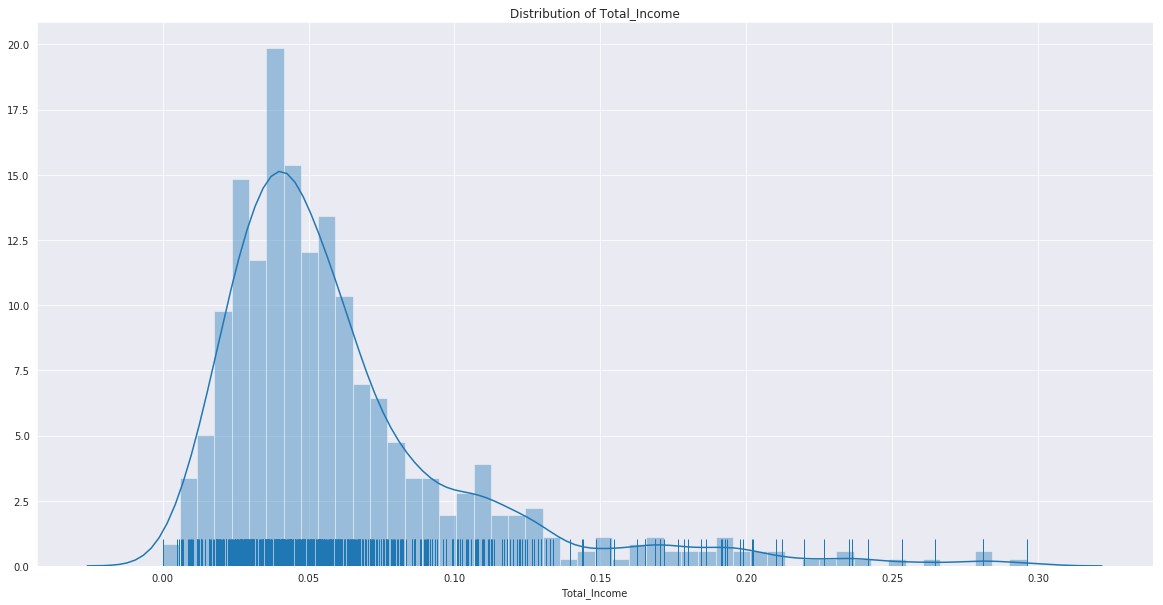

In [158]:
continuous(scaled_train,"Total_Income")

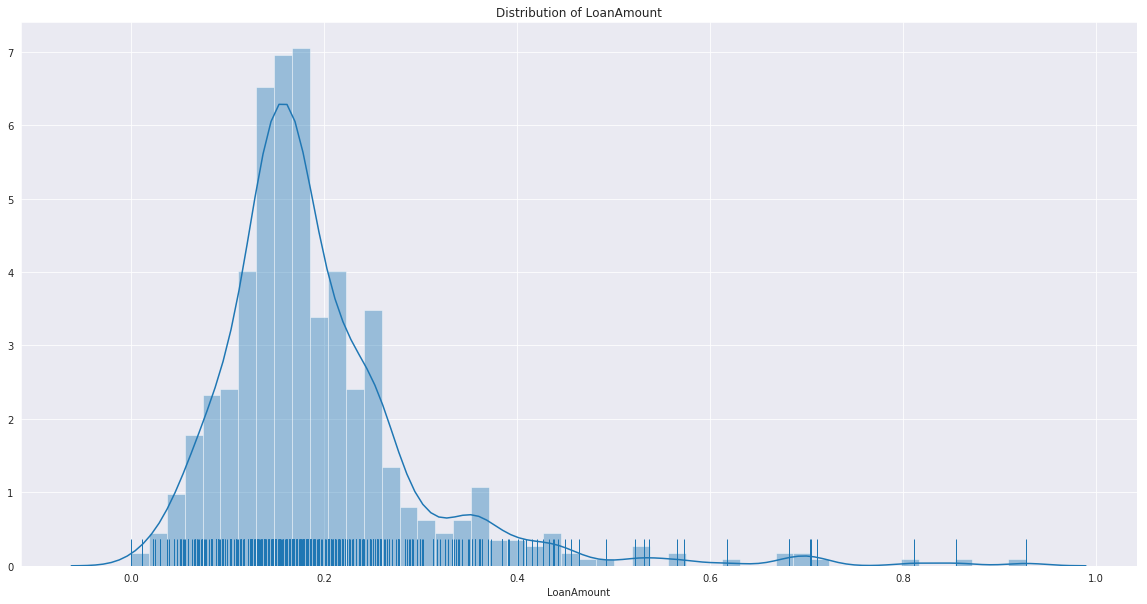

In [159]:
continuous(scaled_train,"LoanAmount")

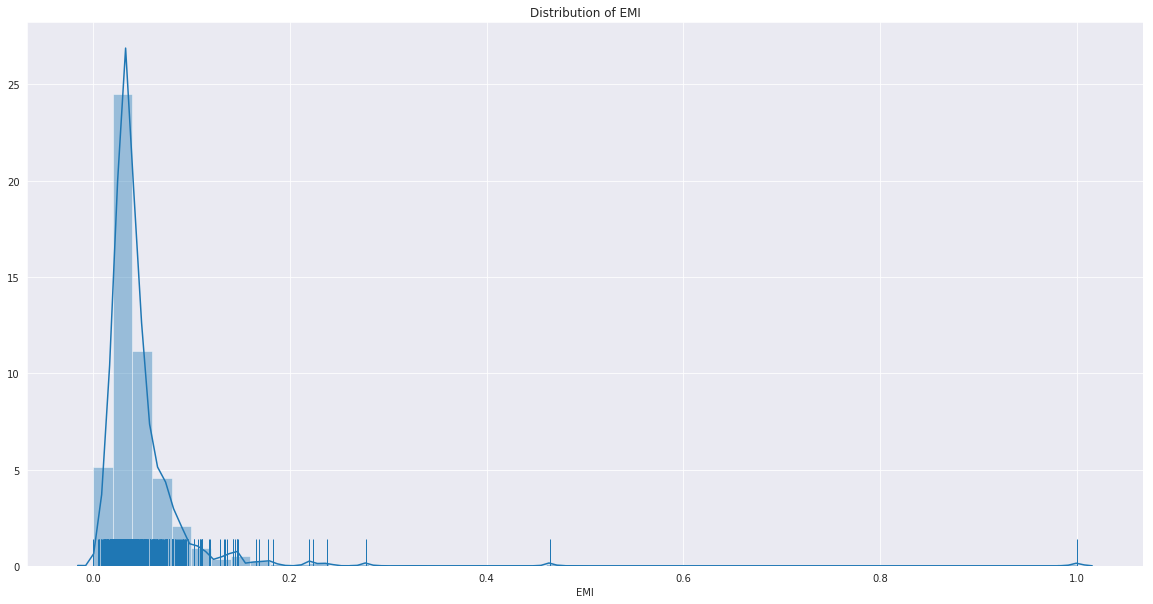

In [160]:
continuous(scaled_train,"EMI")

In [161]:
scaled_train=Z_score(scaled_train,'EMI')

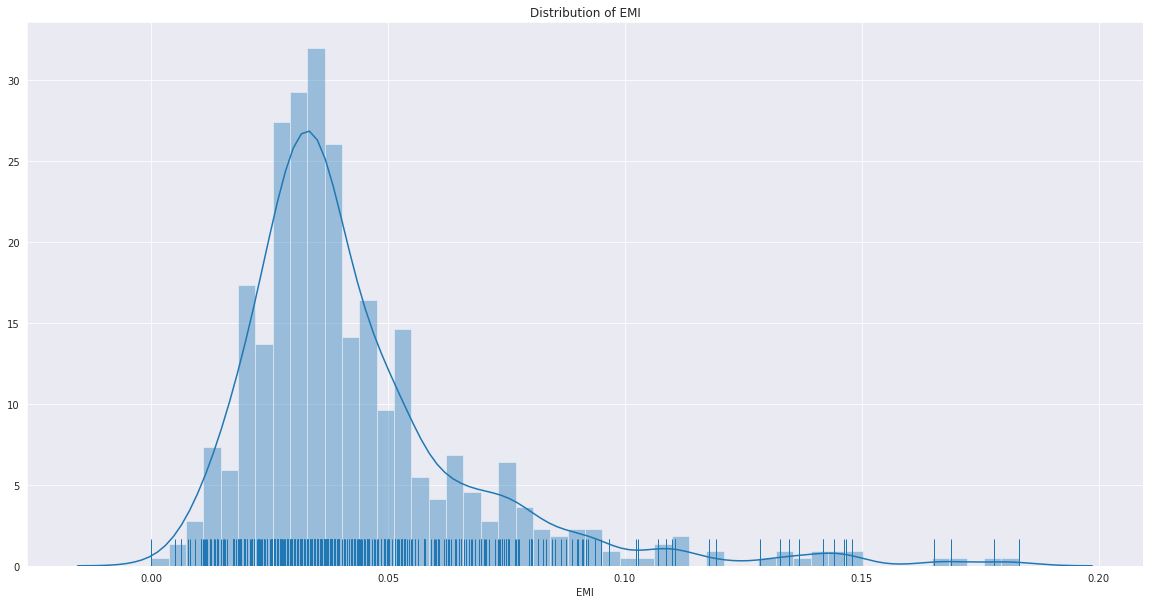

In [162]:
continuous(scaled_train,"EMI")

In [163]:
scaled_train.shape

(598, 9)

In [164]:
### log tranformation no continuous numerical columns

In [165]:
column=['Total_Income','LoanAmount']

In [166]:
Log_Transform(scaled_train,column)

/home/fasial/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


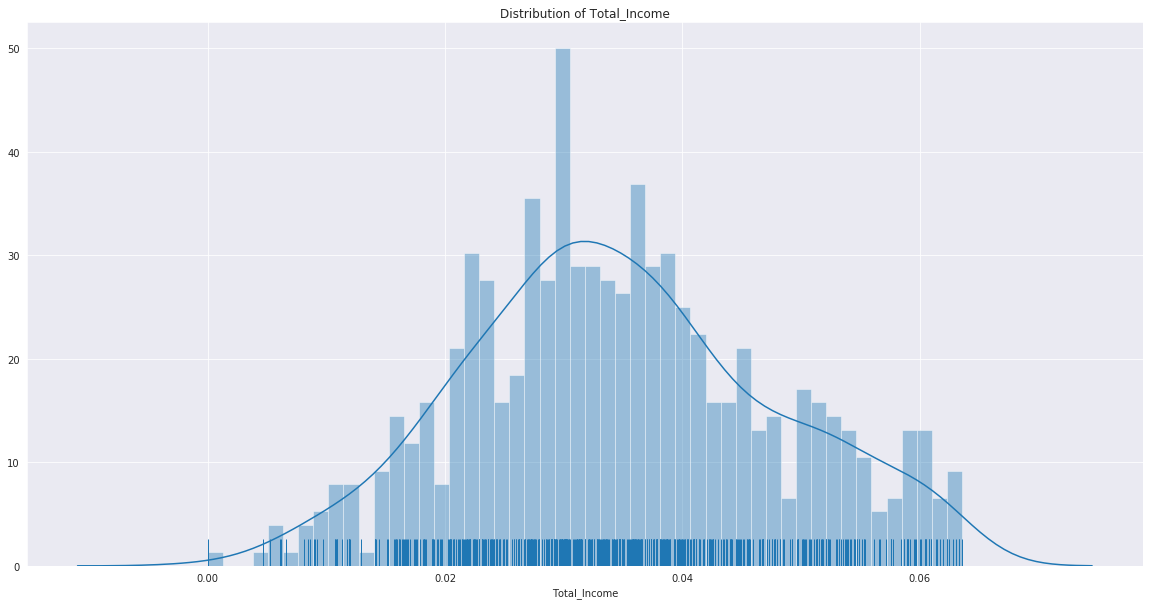

In [167]:
continuous(scaled_train,"Total_Income");

## Modeling

In [168]:
X=scaled_train.drop('Loan_Status',axis=1)
y=scaled_train.Loan_Status

In [169]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

## Logictic Regression

In [170]:
reg=LogisticRegression()
score=cross_val_score(reg,X,y,cv=5)
print(score)
print("Linear Regression Score is {}".format(score.mean()))

[0.80833333 0.8        0.78333333 0.85714286 0.83193277]
Linear Regression Score is 0.8161484593837536


## KNN classifier

In [171]:

for k in range(1,11):
    knn=KNeighborsClassifier(n_neighbors=k)
    score=cross_val_score(knn,X,y,cv=5)
    print("KNN Score is {} for k {}".format(score.mean(),k))

KNN Score is 0.7040056022408964 for k 1
KNN Score is 0.6471008403361345 for k 2
KNN Score is 0.7626190476190475 for k 3
KNN Score is 0.7241036414565827 for k 4
KNN Score is 0.8027450980392157 for k 5
KNN Score is 0.7777170868347338 for k 6
KNN Score is 0.7977450980392156 for k 7
KNN Score is 0.7994117647058824 for k 8
KNN Score is 0.8077731092436975 for k 9
KNN Score is 0.8044397759103642 for k 10


## DecisionTree Classifier

In [172]:

tree_model = DecisionTreeClassifier()
score=cross_val_score(tree_model,X,y,cv=5)
print(score)
print("DecistionTree Score is {}".format(score.mean()))

[0.70833333 0.66666667 0.8        0.77310924 0.73109244]
DecistionTree Score is 0.7358403361344538


### importance of feature

In [173]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)
tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

DecisionTreeClassifier()

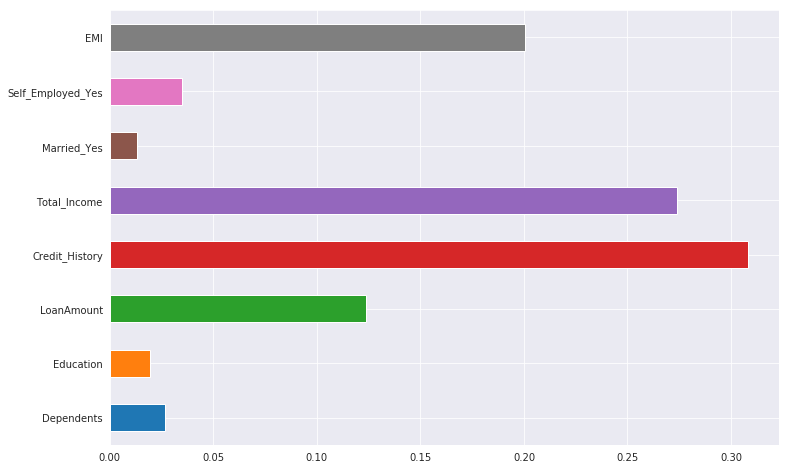

In [174]:
importances = pd.Series(tree_model.feature_importances_,index=X.columns)
importances.plot(kind='barh', figsize=(12,8))

## Random Forest Classifirer

In [175]:

rfc=RandomForestClassifier()
score=cross_val_score(rfc,X,y,cv=5)
print(score)
print("RandomForest Score is {}".format(score.mean()))

[0.78333333 0.73333333 0.775      0.78991597 0.80672269]
RandomForest Score is 0.7776610644257703


### importance of feature

In [176]:

#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)
rfc=RandomForestClassifier()
rfc.fit(X,y);

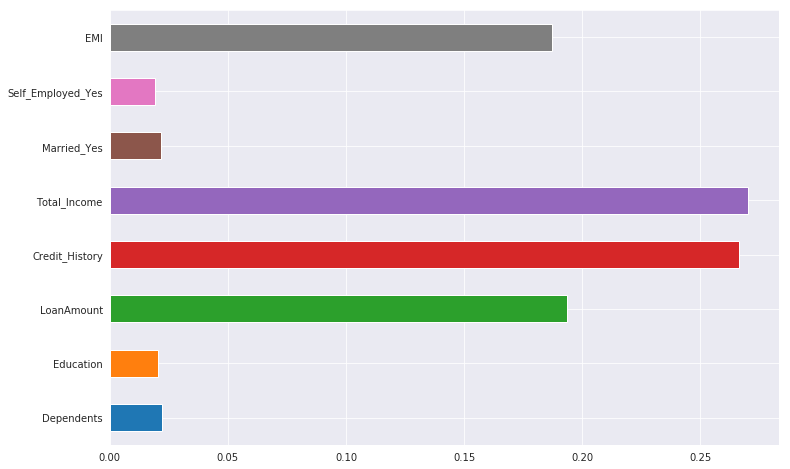

In [177]:
importances = pd.Series(rfc.feature_importances_,index=X.columns)
importances.plot(kind='barh', figsize=(12,8))

## making submission to analyticat vidya for score

In [178]:
reg=LogisticRegression()
reg.fit(X,y)


LogisticRegression()

In [179]:
predictions=reg.predict(scaled_test)

In [180]:
submission=pd.DataFrame({'Loan_ID':test.Loan_ID,'Loan_Status':predictions})

In [181]:
submission.replace({'Loan_Status':{0:'N',1:'Y'}},inplace=True)

In [182]:
submission.Loan_Status.value_counts(normalize=True)

Y    0.839237
N    0.160763
Name: Loan_Status, dtype: float64

In [183]:
filename='loan_prediction.csv'

In [184]:
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: loan_prediction.csv


### Got Accuracy of 0.78